# FoldX
## process both FoldX and DDGun3D

In [1]:
import pandas
import numpy
from copy import deepcopy

import math
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
#foldx_df = pandas.read_csv("../FoldX/Ssym+_experimental.csv", index_col=0)#,usecols=['Protein', 'Mut_pdb','DDG_dir','DDG_inv','FoldX_dir','FoldX_inv']) #.drop(["Unnamed: 0","guess"], axis=1)
#display(foldx_df.head())
#print(foldx_df.columns)

In [3]:
foldx_df = pandas.read_csv("../FoldX/Ssym+_experimental.csv", index_col=0,usecols=['Protein', 'Mut_pdb','Mut_pdb_inv','DDG_dir','DDG_inv','FoldX_dir','FoldX_inv','DDGun3D_dir', 'DDGun3D_inv']) #.drop(["Unnamed: 0","guess"], axis=1)
foldx_df

,Mut_pdb,DDG_dir,DDG_inv,FoldX_dir,FoldX_inv,DDGun3D_dir,DDGun3D_inv,Mut_pdb_inv
Protein,,,,,,,,
1amqA,C191F,-1.60,1.60,-3.458090,-1.167050,0.9,-1.0,F191C
1amqA,C191S,-1.90,1.90,0.178326,-0.117104,-0.5,0.4,S191C
1amqA,C191W,-3.90,3.90,-6.466620,-1.234990,1.0,-1.1,W191C
1amqA,C191Y,-2.30,2.30,-1.795960,0.509656,1.3,-1.4,Y191C
1arrA,P8L,2.49,-2.49,-0.710842,-5.194210,0.1,-0.1,L8P
...,...,...,...,...,...,...,...,...
5ptiA,F22A,-1.20,1.20,-3.354030,0.428306,-2.5,2.8,A22F
5ptiA,F45A,-6.90,6.90,-3.351550,3.440730,-4.4,3.7,A45F
5ptiA,N43G,-5.70,5.70,-1.977350,-0.783265,-1.9,1.5,G43N


In [4]:
_dir=foldx_df.iloc[:,[0,1,3]].rename({'Mut_pdb': 'mut','DDG_dir': 'ddg','FoldX_dir':'foldx'},axis=1)
_dir.head()

,mut,ddg,foldx
Protein,,,
1amqA,C191F,-1.60,-3.458090
1amqA,C191S,-1.90,0.178326
1amqA,C191W,-3.90,-6.466620
1amqA,C191Y,-2.30,-1.795960
1arrA,P8L,2.49,-0.710842


In [5]:
_dir[['ddg','foldx']].corr()

,ddg,foldx
ddg,1.000000,0.566316
foldx,0.566316,1.000000


In [6]:
_inv=foldx_df.iloc[:,[7,2,4]].rename({'Mut_pdb_inv': 'mut','DDG_inv': 'ddg','FoldX_inv':'foldx'},axis=1)
_inv.head()

,mut,ddg,foldx
Protein,,,
1amqA,F191C,1.60,-1.167050
1amqA,S191C,1.90,-0.117104
1amqA,W191C,3.90,-1.234990
1amqA,Y191C,2.30,0.509656
1arrA,L8P,-2.49,-5.194210


In [7]:
foldx_train=pandas.concat([_dir,_inv])
foldx_train.head(), foldx_train.shape

(           mut   ddg     foldx
 Protein                       
 1amqA    C191F -1.60 -3.458090
 1amqA    C191S -1.90  0.178326
 1amqA    C191W -3.90 -6.466620
 1amqA    C191Y -2.30 -1.795960
 1arrA      P8L  2.49 -0.710842,
 (704, 3))

,ddg,foldx
ddg,1.00000,0.50851
foldx,0.50851,1.00000


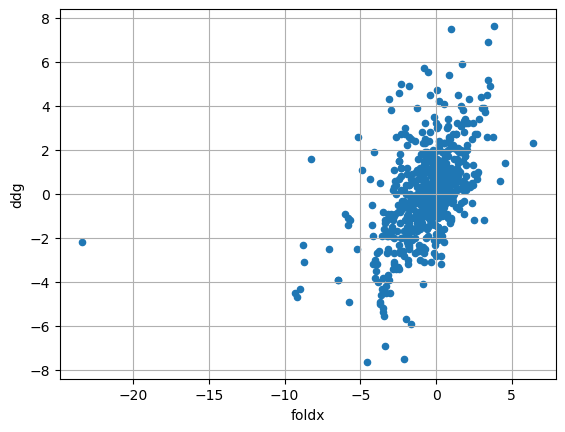

In [8]:
plain_foldx_plot= foldx_train.plot.scatter(x="foldx", y="ddg", grid=True)
foldx_train[['ddg','foldx']].corr()

## compute Rose USC

In [9]:
def unpack_mut(x):
    x['from_aa']= x['mut'][0]
    x['to_aa']= x['mut'][-1]
    return x
    
foldx_train=foldx_train.apply(unpack_mut,axis=1)
foldx_train.head()

,mut,ddg,foldx,from_aa,to_aa
Protein,,,,,
1amqA,C191F,-1.60,-3.458090,C,F
1amqA,C191S,-1.90,0.178326,C,S
1amqA,C191W,-3.90,-6.466620,C,W
1amqA,C191Y,-2.30,-1.795960,C,Y
1arrA,P8L,2.49,-0.710842,P,L


In [10]:
rose=pandas.read_csv('rose1985.csv', index_col='Parameter')
rose

,Rose1985
Parameter,
A,86.6
C,132.3
D,97.8
E,113.9
F,194.1
G,62.9
H,155.8
I,158.0
K,115.5


In [11]:
#esmif_df.head()
def rose_delta(x):
    x['rose_delta']=rose['Rose1985'][x['from_aa']] - rose['Rose1985'][x['to_aa']]
    return x
    
foldx_train = foldx_train.apply(rose_delta, 
               axis=1
              )

In [12]:
foldx_train.head()

,mut,ddg,foldx,from_aa,to_aa,rose_delta
Protein,,,,,,
1amqA,C191F,-1.60,-3.458090,C,F,-61.8
1amqA,C191S,-1.90,0.178326,C,S,46.7
1amqA,C191W,-3.90,-6.466620,C,W,-92.3
1amqA,C191Y,-2.30,-1.795960,C,Y,-45.4
1arrA,P8L,2.49,-0.710842,P,L,-71.2


In [13]:
X_fep= foldx_train[['foldx','rose_delta']].to_numpy()
y= foldx_train['ddg'].to_numpy()

In [14]:
rose_model = LinearRegression(fit_intercept=False).fit(
    X_fep,
    y,
)

rose_model.coef_, rose_model.intercept_, math.sqrt(rose_model.score(X_fep, y))

(array([ 0.39720074, -0.01338495]), 0.0, 0.5737356178393104)

In [15]:
foldx_train['ddfep_rose']=rose_model.predict(X_fep)

1.606980002270817

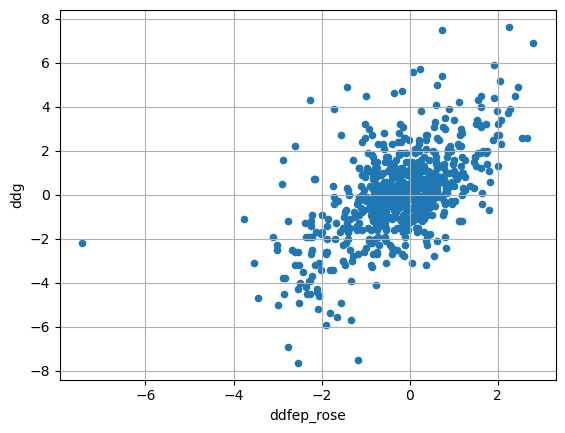

In [16]:
rose_plot= foldx_train.plot.scatter(x='ddfep_rose',y='ddg', grid=True)
math.sqrt(mean_squared_error(foldx_train['ddg'],foldx_train['ddfep_rose']))

In [17]:
foldx_train[['ddg','foldx','ddfep_rose']].corr()

,ddg,foldx,ddfep_rose
ddg,1.000000,0.508510,0.585961
foldx,0.508510,1.000000,0.846883
ddfep_rose,0.585961,0.846883,1.000000


In [18]:
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
rsq=cross_val_score(LinearRegression(fit_intercept=True),
                   X_fep,y,
                   cv=RepeatedStratifiedKFold(n_splits=5,
                                              n_repeats=10,
                                              random_state=2411
                                              #shuffle=True,
                                             ).split(X_fep, y > 0))
rsq

array([0.25446339, 0.30044053, 0.42345805, 0.24813212, 0.37229753,
       0.29127109, 0.3959758 , 0.27590298, 0.33885625, 0.36395938,
       0.34916699, 0.4005738 , 0.38274259, 0.2366771 , 0.25356371,
       0.42659374, 0.27384849, 0.20107644, 0.31179674, 0.47620318,
       0.40278136, 0.29998429, 0.30108489, 0.28733664, 0.36131527,
       0.30322049, 0.38273933, 0.21665764, 0.44903385, 0.30597373,
       0.26300553, 0.42771488, 0.20005344, 0.39186185, 0.33932442,
       0.41556915, 0.33230807, 0.31972162, 0.39846786, 0.18990929,
       0.17758298, 0.34497234, 0.33903817, 0.41699603, 0.39990053,
       0.32441803, 0.33009445, 0.26054432, 0.35315191, 0.36569728])

In [19]:
math.sqrt(rsq.mean()) , math.sqrt(rsq.std())

(0.5740637508552069, 0.2678779431131527)

## ddFEP

In [20]:
aa_labels = [
    "A",
    "R",
    "N",
    "D",
    "C",
    "Q",
    "E",
    "G",
    "H",
    "I",
    "L",
    "K",
    "M",
    "F",
    "P",
    "S",
    "T",
    "W",
    "Y",
    "V",
]

In [21]:
ddfep_opt = deepcopy(foldx_train)
for _ in sorted(aa_labels):
    ddfep_opt[_] = 0
ddfep_opt

,mut,ddg,foldx,from_aa,to_aa,rose_delta,ddfep_rose,A,C,D,...,M,N,P,Q,R,S,T,V,W,Y
Protein,,,,,,,,,,,,,,,,,,,,,
1amqA,C191F,-1.60,-3.458090,C,F,-61.8,-0.546366,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1amqA,C191S,-1.90,0.178326,C,S,46.7,-0.554246,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1amqA,C191W,-3.90,-6.466620,C,W,-92.3,-1.333116,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1amqA,C191Y,-2.30,-1.795960,C,Y,-45.4,-0.105680,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1arrA,P8L,2.49,-0.710842,P,L,-71.2,0.670661,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5ptiA,A22F,1.20,0.428306,A,F,-107.5,1.609005,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5ptiA,A45F,6.90,3.440730,A,F,-107.5,2.805542,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5ptiA,G43N,5.70,-0.783265,G,N,-40.4,0.229638,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
def encode_mutation(x):
    x[x['from_aa']]= -1
    x[x['to_aa']] = 1
    return x

In [23]:
ddfep_opt = ddfep_opt.apply(encode_mutation, axis='columns')
ddgun_train=deepcopy(ddfep_opt)

In [24]:
### fit test

In [25]:
X_optfep= ddfep_opt[['foldx']+sorted(aa_labels)].to_numpy()
y=ddfep_opt['ddg'].to_numpy()
X_optfep.shape, y.shape

((704, 21), (704,))

In [26]:
dd_optfep_model = LinearRegression(fit_intercept=False).fit(
    X_optfep,
    y,
)

In [27]:
dd_optfep_model.coef_, dd_optfep_model.intercept_, math.sqrt(dd_optfep_model.score(X_optfep, y))

(array([ 0.34405849, -0.54786104,  0.69912064, -0.71000046, -0.16356383,
         0.5148939 , -1.08324699, -1.03471692,  1.20357786, -0.85999819,
         0.64640703,  0.06969727, -0.19558428, -0.77814633,  0.12466614,
         1.23416851, -0.42059844,  0.63249059,  0.62866814, -1.03031711,
         1.07034354]),
 0.0,
 0.6748225679599799)

#### ddMBC coefs

In [28]:
kd = {
    "A": 1.800,
    "R": -4.500,
    "N": -3.500,
    "D": -3.500,
    "C": 2.500,
    "Q": -3.500,
    "E": -3.500,
    "G": -0.400,
    "H": -3.200,
    "I": 4.500,
    "L": 3.800,
    "K": -3.900,
    "M": 1.900,
    "F": 2.800,
    "P": -1.600,
    "S": -0.800,
    "T": -0.700,
    "W": -0.900,
    "Y": -1.300,
    "V": 4.200,
}

In [29]:
ddfep_opt['ddfep_opt']=dd_optfep_model.predict(X_optfep)

RMSE: 1.4479369906512354


,ddg,ddfep_opt
ddg,1.000000,0.682508
ddfep_opt,0.682508,1.000000


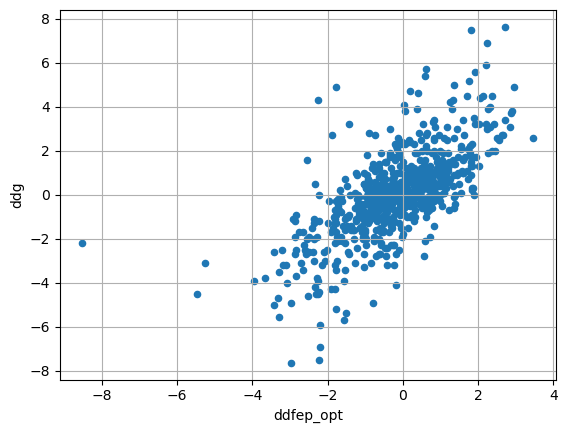

In [30]:
ddfep_opt_plot = ddfep_opt.plot.scatter(x='ddfep_opt',y='ddg', grid=True)

print('RMSE:',math.sqrt(mean_squared_error(ddfep_opt['ddg'],ddfep_opt['ddfep_opt'])))
ddfep_opt[['ddg','ddfep_opt']].corr()

### Crossvalidate

In [31]:
optfep_rsq=cross_val_score(LinearRegression(fit_intercept=True),
                   X_optfep,y,
                   cv=RepeatedStratifiedKFold(n_splits=5,
                                              n_repeats=10,
                                              #shuffle=True,
                                             ).split(X_optfep, y > 0))
optfep_rsq

array([0.49681256, 0.4276827 , 0.43490058, 0.35338612, 0.35540799,
       0.28435948, 0.21280154, 0.43445854, 0.48351549, 0.48363831,
       0.42340128, 0.51692234, 0.47453707, 0.13570406, 0.41120077,
       0.13568468, 0.45355744, 0.4515364 , 0.49194111, 0.38462473,
       0.44922751, 0.23566193, 0.46307664, 0.34763224, 0.55802994,
       0.37478797, 0.21182208, 0.45781282, 0.4633848 , 0.44536749,
       0.42891042, 0.35159902, 0.34541552, 0.46203201, 0.38506597,
       0.49153539, 0.40901316, 0.09751031, 0.50398897, 0.25324819,
       0.41300476, 0.47770309, 0.42998636, 0.2774314 , 0.49171647,
       0.37985513, 0.38931965, 0.44398657, 0.37375322, 0.4336698 ])

In [32]:
_r=numpy.sqrt(optfep_rsq)
_r.mean(), _r.std()

(np.float64(0.6204554431420747), np.float64(0.09416731510461797))

## Test on S669

In [33]:
_669_foldx = pandas.read_csv(
    "../FoldX/Data_s669_with_predictions.csv",
    index_col=None,
    usecols=["Protein", "PDB_Mut", "FoldX_dir", "FoldX_inv","DDGun3D_dir", "DDG_checked_dir", "DDG_checked_inv"],
)
_669_foldx["hash"] = _669_foldx.apply(
    lambda x: "_".join([x["Protein"], x["PDB_Mut"]]), axis=1
)
_669_foldx['experimental']=True
_669_foldx
# list(_669_foldx.columns)

,Protein,PDB_Mut,DDG_checked_dir,FoldX_dir,DDGun3D_dir,FoldX_inv,DDG_checked_inv,hash,experimental
0,1A0FA,S11A,-1.800,0.551703,0.5,-0.571577,1.800,1A0FA_S11A,True
1,1A7VA,A104H,-2.690,0.562630,-0.1,-0.820657,2.690,1A7VA_A104H,True
2,1A7VA,A66H,-1.980,-0.395478,0.5,-0.228698,1.980,1A7VA_A66H,True
3,1A7VA,A91H,-1.700,0.045107,-0.1,-0.590049,1.700,1A7VA_A91H,True
4,1A7VA,D3H,-1.360,-3.565060,0.2,0.056278,1.360,1A7VA_D3H,True
...,...,...,...,...,...,...,...,...,...
664,5JXBA,D329P,-1.440,-0.778776,-0.2,NaN,1.440,5JXBA_D329P,True
665,5OAQA,Y429H,-2.990,-3.408590,-2.4,1.961710,2.990,5OAQA_Y429H,True
666,5VP3A,R39K,0.413,-0.621078,-1.0,0.093390,-0.413,5VP3A_R39K,True
667,5VP3A,S128G,-0.378,-1.227820,-0.8,-0.960481,0.378,5VP3A_S128G,True


In [34]:
_461_muts = pandas.read_csv("../FoldX/s461_muts.csv", sep=" ")

s461_hashes = set(_461_muts.apply(lambda x: "_".join([x["pdb"], x["mut"]]), axis=1))
_461_muts.head()

,pdb,mut,ddg
0,1A0FA,S11A,-1.800
1,1BA3A,H461D,-1.745
2,1BA3A,H489D,0.287
3,1BA3A,H489K,-0.287
4,1BA3A,H489M,-0.263


In [35]:
_669_foldx['s461']=_669_foldx.apply( lambda x: x['hash'] in s461_hashes, axis=1)
#_669_foldx['FoldX_inv'] = - _669_foldx['FoldX_inv']
_669_foldx.head()

,Protein,PDB_Mut,DDG_checked_dir,FoldX_dir,DDGun3D_dir,FoldX_inv,DDG_checked_inv,hash,experimental,s461
0,1A0FA,S11A,-1.80,0.551703,0.5,-0.571577,1.80,1A0FA_S11A,True,True
1,1A7VA,A104H,-2.69,0.562630,-0.1,-0.820657,2.69,1A7VA_A104H,True,False
2,1A7VA,A66H,-1.98,-0.395478,0.5,-0.228698,1.98,1A7VA_A66H,True,False
3,1A7VA,A91H,-1.70,0.045107,-0.1,-0.590049,1.70,1A7VA_A91H,True,False
4,1A7VA,D3H,-1.36,-3.565060,0.2,0.056278,1.36,1A7VA_D3H,True,False


In [36]:
_669_foldx['revmut']=_669_foldx['PDB_Mut'].apply(lambda x: ''.join([x[-1],x[1:-1],x[0]]))
_669_foldx.head()

,Protein,PDB_Mut,DDG_checked_dir,FoldX_dir,DDGun3D_dir,FoldX_inv,DDG_checked_inv,hash,experimental,s461,revmut
0,1A0FA,S11A,-1.80,0.551703,0.5,-0.571577,1.80,1A0FA_S11A,True,True,A11S
1,1A7VA,A104H,-2.69,0.562630,-0.1,-0.820657,2.69,1A7VA_A104H,True,False,H104A
2,1A7VA,A66H,-1.98,-0.395478,0.5,-0.228698,1.98,1A7VA_A66H,True,False,H66A
3,1A7VA,A91H,-1.70,0.045107,-0.1,-0.590049,1.70,1A7VA_A91H,True,False,H91A
4,1A7VA,D3H,-1.36,-3.565060,0.2,0.056278,1.36,1A7VA_D3H,True,False,H3D


In [37]:
_669_dir=_669_foldx.iloc[:,[0,1,2,3,-3,-2]].rename({'PDB_Mut': 'mut','DDG_checked_dir': 'ddg','FoldX_dir':'foldx'},axis=1).apply(unpack_mut, axis=1)
_669_dir.head()

,Protein,mut,ddg,foldx,experimental,s461,from_aa,to_aa
0,1A0FA,S11A,-1.80,0.551703,True,True,S,A
1,1A7VA,A104H,-2.69,0.562630,True,False,A,H
2,1A7VA,A66H,-1.98,-0.395478,True,False,A,H
3,1A7VA,A91H,-1.70,0.045107,True,False,A,H
4,1A7VA,D3H,-1.36,-3.565060,True,False,D,H


In [38]:
_669_dir[['ddg','foldx']].corr()

,ddg,foldx
ddg,1.000000,0.214081
foldx,0.214081,1.000000


In [39]:
_669_inv=_669_foldx.iloc[:,[0,6,5,-3,-2,-1]].rename({'revmut': 'mut','DDG_checked_inv': 'ddg','FoldX_inv':'foldx'},axis=1).apply(unpack_mut, axis=1)
_669_inv['experimental']= False
_669_inv.head()

,Protein,ddg,foldx,experimental,s461,mut,from_aa,to_aa
0,1A0FA,1.80,-0.571577,False,True,A11S,A,S
1,1A7VA,2.69,-0.820657,False,False,H104A,H,A
2,1A7VA,1.98,-0.228698,False,False,H66A,H,A
3,1A7VA,1.70,-0.590049,False,False,H91A,H,A
4,1A7VA,1.36,0.056278,False,False,H3D,H,D


In [40]:
_669_inv[['ddg','foldx']].corr()

,ddg,foldx
ddg,1.000000,0.217521
foldx,0.217521,1.000000


In [41]:
_669_full=pandas.concat([_669_dir,_669_inv], ignore_index=True)
_669_full.shape

(1338, 8)

In [42]:
_669_full[['ddg','foldx']].corr()

,ddg,foldx
ddg,1.000000,0.306655
foldx,0.306655,1.000000


RMSE: 2.3979470963814915


,ddg,foldx
ddg,1.000000,0.306655
foldx,0.306655,1.000000


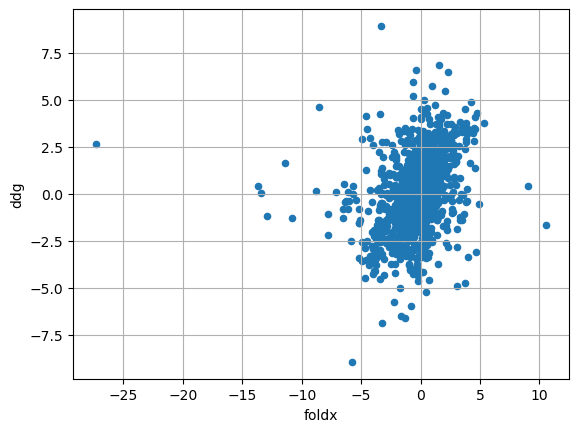

In [43]:
_669_full_clean = _669_full.dropna()
foldx_669_plot = _669_full_clean.plot.scatter(x="foldx", y="ddg", grid=True)

print("RMSE:", math.sqrt(mean_squared_error(_669_full_clean["ddg"], _669_full_clean["foldx"])))
_669_full_clean[['ddg','foldx']].corr()

In [44]:
## Go ddMBC
foldx_s669 = deepcopy(_669_full_clean.apply(rose_delta, axis=1))
foldx_s669

,Protein,mut,ddg,foldx,experimental,s461,from_aa,to_aa,rose_delta
0,1A0FA,S11A,-1.800,0.551703,True,True,S,A,-1.0
1,1A7VA,A104H,-2.690,0.562630,True,False,A,H,-69.2
2,1A7VA,A66H,-1.980,-0.395478,True,False,A,H,-69.2
3,1A7VA,A91H,-1.700,0.045107,True,False,A,H,-69.2
4,1A7VA,D3H,-1.360,-3.565060,True,False,D,H,-58.0
...,...,...,...,...,...,...,...,...,...
1331,4YEFA,V134T,0.930,-1.952810,False,False,V,T,34.5
1334,5OAQA,H429Y,2.990,1.961710,False,True,H,Y,-21.9
1335,5VP3A,K39R,-0.413,0.093390,False,False,K,R,-46.7
1336,5VP3A,G128S,0.378,-0.960481,False,False,G,S,-22.7


In [45]:
for _ in sorted(aa_labels):
    foldx_s669[_]=0
foldx_s669=foldx_s669.apply(encode_mutation, axis=1)

In [46]:
X669_optfep= foldx_s669[['foldx']+sorted(aa_labels)].to_numpy()
X669_rose=foldx_s669[['foldx','rose_delta']]
X669_optfep.shape

(1328, 21)

In [47]:
foldx_s669['ddfep_opt']=dd_optfep_model.predict(X669_optfep)
foldx_s669['ddfep_rose']=rose_model.predict(X669_rose)

/usr/local/ivan/Unito/conda/envs/datacrunch/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


foldx S669 RMSE: 2.3979470963814915
ddfep_opt S669 RMSE: 1.8248107136723528
ddfep_rose S669 RMSE: 1.7372694999577925


,ddg,ddfep_opt,ddfep_rose
ddg,1.000000,0.416724,0.449194
ddfep_opt,0.416724,1.000000,0.806939
ddfep_rose,0.449194,0.806939,1.000000


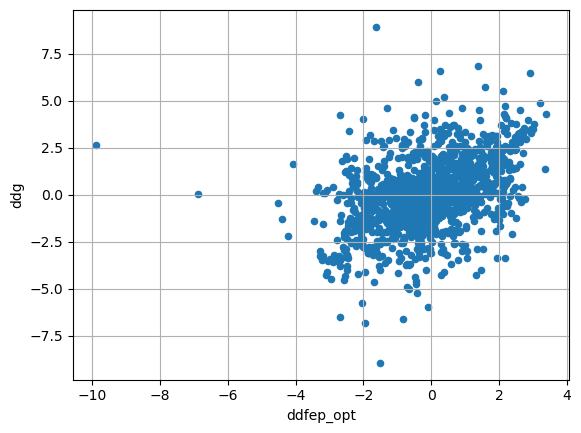

In [48]:
foldx_s669_plot = foldx_s669.plot.scatter(x="ddfep_opt", y="ddg", grid=True)
for _ in ["foldx", "ddfep_opt", "ddfep_rose"]:
    print(
        _, "S669 RMSE:", math.sqrt(mean_squared_error(foldx_s669["ddg"], foldx_s669[_]))
    )
foldx_s669[["ddg", "ddfep_opt", "ddfep_rose"]].corr()

In [49]:
foldx_s669[foldx_s669['experimental'] == True][['ddg','foldx','ddfep_opt','ddfep_rose']].corr()

,ddg,foldx,ddfep_opt,ddfep_rose
ddg,1.000000,0.214081,0.307288,0.334008
foldx,0.214081,1.000000,0.609177,0.818283
ddfep_opt,0.307288,0.609177,1.000000,0.756225
ddfep_rose,0.334008,0.818283,0.756225,1.000000


In [50]:
foldx_s669[foldx_s669['experimental'] == False][['ddg','foldx','ddfep_opt','ddfep_rose']].corr()

,ddg,foldx,ddfep_opt,ddfep_rose
ddg,1.000000,0.217521,0.286412,0.311372
foldx,0.217521,1.000000,0.697787,0.865488
ddfep_opt,0.286412,0.697787,1.000000,0.796473
ddfep_rose,0.311372,0.865488,0.796473,1.000000


## S461

In [51]:
foldx_s461=deepcopy(foldx_s669[ foldx_s669['s461']])
foldx_s461.shape

(920, 31)

In [52]:
print('RMSE foldx:',math.sqrt(mean_squared_error(foldx_s461['ddg'],foldx_s461['foldx'])))

RMSE foldx: 2.0251642437125095


foldx S461 RMSE: 2.0251642437125095
ddfep_opt S461 RMSE: 1.4436105408639792
ddfep_rose S461 RMSE: 1.366766386815321


,ddg,foldx,ddfep_opt,ddfep_rose
ddg,1.000000,0.431673,0.576755,0.609114
foldx,0.431673,1.000000,0.700123,0.849142
ddfep_opt,0.576755,0.700123,1.000000,0.862034
ddfep_rose,0.609114,0.849142,0.862034,1.000000


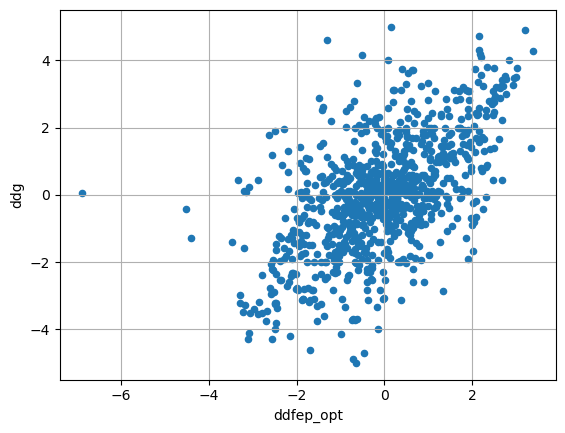

In [53]:
foldx_s461_plot = foldx_s461.plot.scatter(x='ddfep_opt',y='ddg', grid=True)
for _ in ["foldx", "ddfep_opt", "ddfep_rose"]:
    print(
        _, "S461 RMSE:", math.sqrt(mean_squared_error(foldx_s461["ddg"], foldx_s461[_]))
    )
foldx_s461[['ddg','foldx','ddfep_opt','ddfep_rose']].corr()

In [54]:
foldx_s461[foldx_s461['experimental'] == True][['ddg','foldx','ddfep_opt']].corr()

,ddg,foldx,ddfep_opt
ddg,1.000000,0.213666,0.382717
foldx,0.213666,1.000000,0.649591
ddfep_opt,0.382717,0.649591,1.000000


In [55]:
foldx_s461[foldx_s461['experimental'] == False][['ddg','foldx','ddfep_opt']].corr()

,ddg,foldx,ddfep_opt
ddg,1.000000,0.397641,0.445341
foldx,0.397641,1.000000,0.662150
ddfep_opt,0.445341,0.662150,1.000000
